In [14]:
import torch
import math
import torch.distributions as D
import matplotlib.pyplot as plt

def get_p(r, a):
    one = r*torch.cos(a)+.25
    two = r*torch.sin(a)
    return torch.stack([one, two])

def get_x(r, a, theta):
    p_val = get_p(r, a)
    new1 = -1*torch.sum(theta, -1).abs()/math.sqrt(2)
    new2 = (-1*theta[..., 0])/math.sqrt(2)
    new = torch.stack([new1, new2])
    return (p_val+new).T

def generate_data(n_pts, return_theta=False):
    prior = D.Uniform(torch.tensor([-1.]), torch.tensor([1.]))
    a_dist = D.Uniform(-math.pi/2, math.pi/2)
    r_dist = D.Normal(0.1, .01)

    theta, a, r = prior.sample((n_pts,)), a_dist.sample((n_pts,)), r_dist.sample((n_pts,))
    x = get_x(r, a, theta)
    if return_theta:
        return theta, x
    else:
        return x

In [15]:
from pyknos.nflows import flows, transforms
from functools import partial
from typing import Optional
from warnings import warn

from pyknos.nflows import distributions as distributions_
from pyknos.nflows import flows, transforms
from pyknos.nflows.nn import nets
from pyknos.nflows.transforms.splines import rational_quadratic
from torch import Tensor, nn, relu, tanh, tensor, uint8

from sbi.utils.sbiutils import (
    standardizing_net,
    standardizing_transform,
    z_score_parser,
)
from sbi.utils.torchutils import create_alternating_binary_mask
from sbi.utils.user_input_checks import check_data_device, check_embedding_net_device

class ContextSplineMap(nn.Module):
    """
    Neural network from `context` to the spline parameters.
    We cannot use the resnet as conditioner to learn each dimension conditioned
    on the other dimensions (because there is only one). Instead, we learn the
    spline parameters directly. In the case of conditinal density estimation,
    we make the spline parameters conditional on the context. This is
    implemented in this class.
    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_features: int,
        context_features: int,
        hidden_layers: int,
    ):
        """
        Initialize neural network that learns to predict spline parameters.
        Args:
            in_features: Unused since there is no `conditioner` in 1D.
            out_features: Number of spline parameters.
            hidden_features: Number of hidden units.
            context_features: Number of context features.
        """
        super().__init__()
        # `self.hidden_features` is only defined such that nflows can infer
        # a scaling factor for initializations.
        self.hidden_features = hidden_features

        # Use a non-linearity because otherwise, there will be a linear
        # mapping from context features onto distribution parameters.

        # Initialize with input layer.
        layer_list = [nn.Linear(context_features, hidden_features), nn.ReLU()]
        # Add hidden layers.
        layer_list += [
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
        ] * hidden_layers
        # Add output layer.
        layer_list += [nn.Linear(hidden_features, out_features)]
        self.spline_predictor = nn.Sequential(*layer_list)

    def __call__(self, inputs: Tensor, context: Tensor, *args, **kwargs) -> Tensor:
        """
        Return parameters of the spline given the context.
        Args:
            inputs: Unused. It would usually be the other dimensions, but in
                1D, there are no other dimensions.
            context: Context features.
        Returns:
            Spline parameters.
        """
        return self.spline_predictor(context)

# Declan: this code from SBI library
def build_nsf(
    batch_x: Tensor,
    batch_y: Tensor,
    z_score_x: Optional[str] = "independent",
    z_score_y: Optional[str] = "independent",
    hidden_features: int = 50,
    num_transforms: int = 5,
    num_bins: int = 10,
    embedding_net: nn.Module = nn.Identity(),
    tail_bound: float = 3.0,
    hidden_layers_spline_context: int = 1,
    num_blocks: int = 2,
    dropout_probability: float = 0.0,
    use_batch_norm: bool = False,
    **kwargs,
) -> nn.Module:
    """Builds NSF p(x|y).
    Args:
        batch_x: Batch of xs, used to infer dimensionality and (optional) z-scoring.
        batch_y: Batch of ys, used to infer dimensionality and (optional) z-scoring.
        z_score_x: Whether to z-score xs passing into the network, can be one of:
            - `none`, or None: do not z-score.
            - `independent`: z-score each dimension independently.
            - `structured`: treat dimensions as related, therefore compute mean and std
            over the entire batch, instead of per-dimension. Should be used when each
            sample is, for example, a time series or an image.
        z_score_y: Whether to z-score ys passing into the network, same options as
            z_score_x.
        hidden_features: Number of hidden features.
        num_transforms: Number of transforms.
        num_bins: Number of bins used for the splines.
        embedding_net: Optional embedding network for y.
        tail_bound: tail bound for each spline.
        hidden_layers_spline_context: number of hidden layers of the spline context net
            for one-dimensional x.
        num_blocks: number of blocks used for residual net for context embedding.
        dropout_probability: dropout probability for regularization in residual net.
        use_batch_norm: whether to use batch norm in residual net.
        kwargs: Additional arguments that are passed by the build function but are not
            relevant for maf and are therefore ignored.
    Returns:
        Neural network.
    """
    x_numel = batch_x[0].numel()
    # Infer the output dimensionality of the embedding_net by making a forward pass.
    check_data_device(batch_x, batch_y)
    check_embedding_net_device(embedding_net=embedding_net, datum=batch_y)
    y_numel = embedding_net(batch_y[:1]).numel()

    # Define mask function to alternate between predicted x-dimensions.
    def mask_in_layer(i):
        return create_alternating_binary_mask(features=x_numel, even=(i % 2 == 0))

    # If x is just a scalar then use a dummy mask and learn spline parameters using the
    # conditioning variables only.
    if x_numel == 1:
        # Conditioner ignores the data and uses the conditioning variables only.
        conditioner = partial(
            ContextSplineMap,
            hidden_features=hidden_features,
            context_features=y_numel,
            hidden_layers=hidden_layers_spline_context,
        )
    else:
        # Use conditional resnet as spline conditioner.
        conditioner = partial(
            nets.ResidualNet,
            hidden_features=hidden_features,
            context_features=y_numel,
            num_blocks=num_blocks,
            activation=relu,
            dropout_probability=dropout_probability,
            use_batch_norm=use_batch_norm,
        )

    # Stack spline transforms.
    transform_list = []
    for i in range(num_transforms):
        block = [
            transforms.PiecewiseRationalQuadraticCouplingTransform(
                mask=mask_in_layer(i) if x_numel > 1 else tensor([1], dtype=uint8),
                transform_net_create_fn=conditioner,
                num_bins=num_bins,
                tails="linear",
                tail_bound=tail_bound,
                apply_unconditional_transform=False,
            )
        ]
        # Add LU transform only for high D x. Permutation makes sense only for more than
        # one feature.
        if x_numel > 1:
            block.append(
                transforms.LULinear(x_numel, identity_init=True),
            )
        transform_list += block

    z_score_x_bool, structured_x = z_score_parser(z_score_x)
    if z_score_x_bool:
        # Prepend standardizing transform to nsf transforms.
        transform_list = [
            standardizing_transform(batch_x, structured_x)
        ] + transform_list

    z_score_y_bool, structured_y = z_score_parser(z_score_y)
    if z_score_y_bool:
        # Prepend standardizing transform to y-embedding.
        embedding_net = nn.Sequential(
            standardizing_net(batch_y, structured_y), embedding_net
        )

    distribution = distributions_.StandardNormal((x_numel,))

    # Combine transforms.
    transform = transforms.CompositeTransform(transform_list)
    neural_net = flows.Flow(transform, distribution, embedding_net)

    return neural_net



class EmbeddingNet(nn.Module):
    def __init__(self, dim):
        super(EmbeddingNet, self).__init__()
        self.context_dim = dim
        self.dense = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
        )


    def forward(self, x):
        '''
        Assumes context x is of shape (batch_size, self.context_dim)
        '''
        return self.dense(x)


In [19]:
theta, x = generate_data(100, return_theta=True) 

prior = D.Uniform(torch.tensor([-1.]), torch.tensor([1.]))
a_dist = D.Uniform(-math.pi/2, math.pi/2)
r_dist = D.Normal(0.1, .01)
mb_size=100
device='cuda:0'
kwargs = {'prior': prior,
        'a_dist': a_dist,
        'r_dist': r_dist}

# EXAMPLE BATCH FOR SHAPES
z_dim = prior.sample().shape[-1]
x_dim = x.shape[-1]
num_obs_flow = mb_size
fake_zs = torch.randn((mb_size, z_dim))
fake_xs = torch.randn((mb_size, x_dim))
encoder = build_nsf(fake_zs, fake_xs, z_score_x='none', z_score_y='none')

encoder.to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)

In [20]:
for j in range(5000):
    theta, x = generate_data(mb_size, return_theta=True)
    optimizer.zero_grad()
    loss = -1*encoder.log_prob(theta.to(device), x.to(device)).mean()
    loss.backward()
    optimizer.step()
    print('Iteration {}: loss {}'.format(j, loss.item()))

Iteration 0: loss 1.376520037651062
Iteration 1: loss 1.2266581058502197
Iteration 2: loss 1.1976221799850464
Iteration 3: loss 1.230082392692566
Iteration 4: loss 1.166643500328064
Iteration 5: loss 1.0738427639007568
Iteration 6: loss 1.2030832767486572
Iteration 7: loss 1.0469608306884766
Iteration 8: loss 1.0662074089050293
Iteration 9: loss 1.1161472797393799
Iteration 10: loss 1.0854778289794922
Iteration 11: loss 1.126595377922058
Iteration 12: loss 1.1174176931381226
Iteration 13: loss 1.0462520122528076
Iteration 14: loss 0.9655378460884094
Iteration 15: loss 1.050117015838623
Iteration 16: loss 0.9352047443389893
Iteration 17: loss 0.9352251887321472
Iteration 18: loss 0.9603620767593384
Iteration 19: loss 0.9666975140571594
Iteration 20: loss 0.927326500415802
Iteration 21: loss 0.9115054607391357
Iteration 22: loss 0.968351423740387
Iteration 23: loss 0.8201296329498291
Iteration 24: loss 0.8687020540237427
Iteration 25: loss 0.837331235408783
Iteration 26: loss 0.763216555

In [25]:
def log_post(x, theta, **kwargs):
    '''vectorized version of the above in theta for fixed x'''
    assert theta.shape[1] == 1, "not yet implemented for evaluation on multiple points at once"
    r_dist = kwargs['r_dist']
    new1 = -1*torch.sum(theta, 1).abs()/math.sqrt(2)
    new2 = (-1*theta[:,0])/math.sqrt(2)
    new = torch.stack([new1, new2]).T
    p = x-new
    print(p)
    u = p[:,0]-.25
    v = p[:,1]
    r = torch.sqrt(u ** 2 + v ** 2)  # note the angle distribution is uniform
    to_adjust = r_dist.log_prob(r)
    adjusted = torch.where(u < 0.0, -torch.inf, to_adjust.double())
    return adjusted

# Code to plot the true posterior density
def plot(j, x, encoder, **kwargs):
    device = 'cuda:0'

    # Plot exact density
    eval_pts = torch.arange(-1., 1., .01).unsqueeze(1)
    lps = log_post(x[j], eval_pts, **kwargs)
    X = eval_pts
    Z = lps.view(X.shape)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,8))
    ax[0].plot(X.numpy(), Z.exp().numpy())
    ax[0].set_title('Exact')
    

    # eval_pts = torch.arange(-1., 1., .01).unsqueeze(1)
    lps = encoder.log_prob(eval_pts.to(device), x[j].view(1,-1).repeat(eval_pts.shape[0],1).to(device)).detach()
    # X, Y = torch.meshgrid(vals, vals)
    Z = lps.view(X.shape)
    ax[1].plot(X.cpu().numpy(), Z.cpu().exp().numpy())
    ax[1].set_title('Approximate Posterior Flow')

tensor([[ 6.9996e-01, -4.0212e-01],
        [ 6.9289e-01, -3.9505e-01],
        [ 6.8582e-01, -3.8798e-01],
        [ 6.7875e-01, -3.8091e-01],
        [ 6.7168e-01, -3.7384e-01],
        [ 6.6461e-01, -3.6677e-01],
        [ 6.5754e-01, -3.5970e-01],
        [ 6.5047e-01, -3.5262e-01],
        [ 6.4340e-01, -3.4555e-01],
        [ 6.3632e-01, -3.3848e-01],
        [ 6.2925e-01, -3.3141e-01],
        [ 6.2218e-01, -3.2434e-01],
        [ 6.1511e-01, -3.1727e-01],
        [ 6.0804e-01, -3.1020e-01],
        [ 6.0097e-01, -3.0313e-01],
        [ 5.9390e-01, -2.9606e-01],
        [ 5.8683e-01, -2.8898e-01],
        [ 5.7976e-01, -2.8191e-01],
        [ 5.7269e-01, -2.7484e-01],
        [ 5.6561e-01, -2.6777e-01],
        [ 5.5854e-01, -2.6070e-01],
        [ 5.5147e-01, -2.5363e-01],
        [ 5.4440e-01, -2.4656e-01],
        [ 5.3733e-01, -2.3949e-01],
        [ 5.3026e-01, -2.3242e-01],
        [ 5.2319e-01, -2.2535e-01],
        [ 5.1612e-01, -2.1827e-01],
        [ 5.0905e-01, -2.112

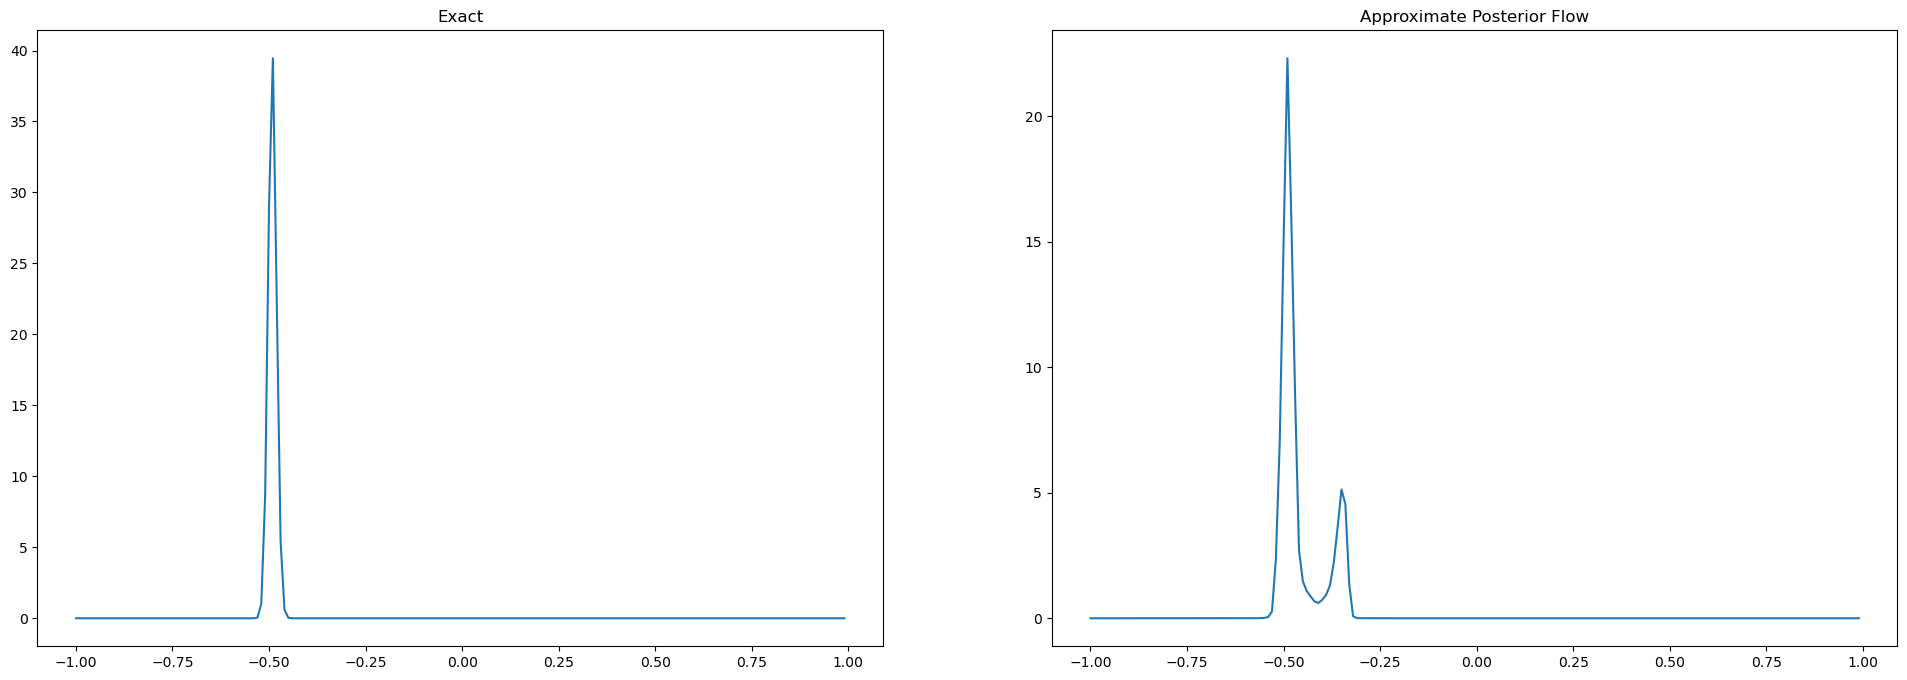

In [26]:
plot(j=5, x=x, encoder=encoder, **kwargs)